# Feature Overview

This notebook provides a simple overview of the basic functionality of PySINDy. In addition to demonstrating the basic usage for fitting a SINDy model, we demonstrate several means of customizing the SINDy fitting procedure. These include different forms of input data, different optimization methods, different differentiation methods, and custom feature libraries.

An interactive version of this notebook is available on binder.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso

import pysindy as ps

In [2]:
# Seed the random number generators for reproducibility
np.random.seed(100)

## Basic usage

In [3]:
def lorenz(z, t):
    return [
        10 * (z[1] - z[0]),
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - (8 / 3) * z[2]
    ]

### Train the model

In [4]:
# Generate measurement data
dt = .002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)

In [5]:
# Instantiate and fit the SINDy model
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### Assess results on a test trajectory

In [6]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz, x0_test, t_test)  

# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, t=dt))

Model score: 1.000000


### Predict derivatives with learned model

/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


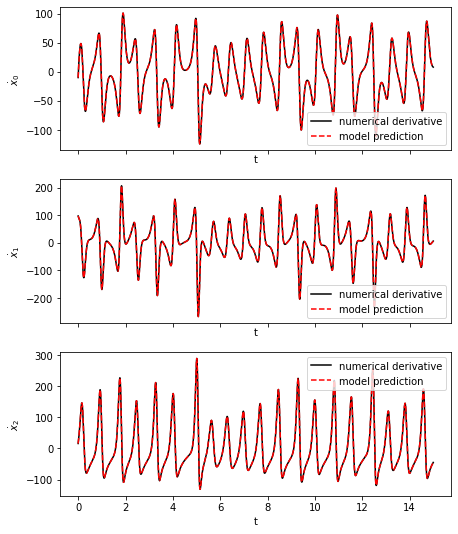

In [7]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

### Simulate forward in time

/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


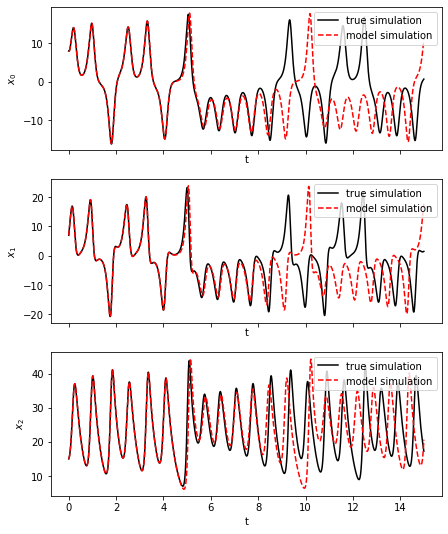

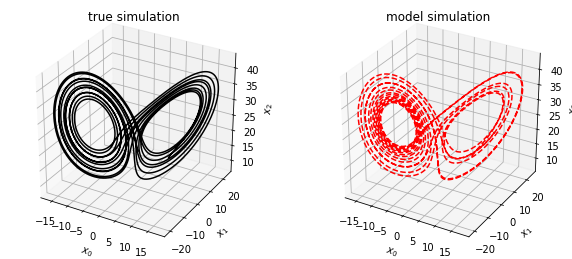

In [8]:
# Evolve the new initial condition in time with the SINDy model
x_test_sim = model.simulate(x0_test, t_test)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()

## Different forms of input data

Here we explore different types of input data accepted by the the `SINDy` class.

### Single trajectory, pass in collection times

In [9]:
model = ps.SINDy()
model.fit(x_train, t=t_train)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### Single trajectory, set default timestep
Since we used a uniform timestep when defining `t_train` we can tell set a default timestep to be used whenever `t` isn't passed in.

In [10]:
model = ps.SINDy(t_default=dt)
model.fit(x_train)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### Single trajectory, pass in pre-computed derivatives

In [11]:
x_dot_true = np.zeros(x_train.shape)
for i in range(t_train.size):
    x_dot_true[i] = lorenz(x_train[i], t_train[i])
    
model = ps.SINDy()
model.fit(x_train, t=t_train, x_dot=x_dot_true)
model.print()

x0' = -10.000 x0 + 10.000 x1
x1' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
x2' = -2.667 x2 + 1.000 x0 x1


In [12]:
model = ps.SINDy()

### Multiple trajectories
We use the Lorenz equations to evolve multiple different initial conditions forward in time, passing all the trajectories into a single `SINDy` object. Note that `x_train_multi` is a list of 2D numpy arrays.

In [13]:
n_trajectories = 20
x0s = np.array([36, 48, 41]) * (
    np.random.rand(n_trajectories, 3) - 0.5
) + np.array([0, 0, 25])
x_train_multi = []
for i in range(n_trajectories):
    x_train_multi.append(odeint(lorenz, x0s[i], t_train))

model = ps.SINDy()
model.fit(x_train_multi, t=dt, multiple_trajectories=True)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### Multiple trajectories, different lengths of time
This example is similar to the previous one, but each trajectory consists of a different number of measurements.

In [14]:
n_trajectories = 20
x0s = np.array([36, 48, 41]) * (
    np.random.rand(n_trajectories, 3) - 0.5
) + np.array([0, 0, 25])
x_train_multi = []
t_train_multi = []
for i in range(n_trajectories):
    n_samples = np.random.randint(500, 1500)
    t = np.arange(0, n_samples * dt, dt)
    x_train_multi.append(odeint(lorenz, x0s[i], t))
    t_train_multi.append(t)

model = ps.SINDy()
model.fit(x_train_multi, t=t_train_multi, multiple_trajectories=True)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.994 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### Discrete time dynamical system (map)

In [15]:
def f(x):
    return 3.6 * x * (1 - x)


n_steps = 1000
eps = 0.001  # Noise level
x_train_map = np.zeros((n_steps))
x_train_map[0] = 0.5
for i in range(1, n_steps):
    x_train_map[i] = f(x_train_map[i - 1]) + eps * np.random.randn()

model = ps.SINDy(discrete_time=True)
model.fit(x_train_map)
model.print()

x0[k+1] = 3.600 x0[k] + -3.600 x0[k]^2


### Pandas DataFrame

In [16]:
import pandas as pd

# Create a dataframe with entries corresponding to measurements and
# indexed by the time at which the measurements were taken
df = pd.DataFrame(data=x_train, columns=['x', 'y', 'z'], index=t_train)

# The column names can be used as feature names
model = ps.SINDy(feature_names=df.columns)

# Everything needs to be converted to numpy arrays to be passed in
model.fit(df.values, t=df.index.values)
model.print()

x' = -9.999 x + 9.999 y
y' = 27.992 x + -0.999 y + -1.000 x z
z' = -2.666 z + 1.000 x y


## Optimization options
In this section we provide examples of different parameters accepted by the built-in methods `STLSQ`, `SR3` and `ConstrainedSR3`. We also show how to use a scikit-learn sparse regressor with PySINDy.

### STLSQ - change parameters

In [17]:
stlsq_optimizer = ps.STLSQ(threshold=.01, alpha=.5)

model = ps.SINDy(optimizer=stlsq_optimizer)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### SR3

In [18]:
sr3_optimizer = ps.SR3(threshold=0.1, nu=1)

model = ps.SINDy(optimizer=sr3_optimizer)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### SR3 - with trimming
`SR3` is capable of automatically trimming outliers from training data. Specifying the parameter `trimming_fraction` tells the method what fraction of samples should be trimmed.

In [19]:
corrupted_inds = np.random.randint(0, len(x_train), size=len(x_train) // 30)
x_train_corrupted = x_train.copy()
x_train_corrupted[corrupted_inds] += np.random.standard_normal((len(corrupted_inds), 3))

# Without trimming
sr3_optimizer = ps.SR3()
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train_corrupted, t=dt)
print("Without trimming")
model.print()

# With trimming
sr3_optimizer = ps.SR3(trimming_fraction=0.1)
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train_corrupted, t=dt)
print("\nWith trimming")
model.print()

Without trimming
x0' = -0.046 1 + -9.937 x0 + 9.943 x1 + 0.002 x2
x1' = -0.135 1 + 27.971 x0 + -0.993 x1 + 0.007 x2 + -1.000 x0 x2
x2' = -0.065 1 + 0.019 x0 + -0.009 x1 + -2.661 x2 + 0.998 x0 x1

With trimming
x0' = -9.937 x0 + 9.943 x1
x1' = 27.980 x0 + -0.995 x1 + -1.000 x0 x2
x2' = -2.662 x2 + 0.998 x0 x1


/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  ConvergenceWarning,


### ConstrainedSR3
We can impose linear equality and inequality constraints on the coefficients in the `SINDy` model using the `ConstrainedSR3` class. Below we constrain the x0 coefficient in the second equation to be exactly 28 and the x0 and x1 coefficients in the first equations to be negatives of one another.

In [20]:
# Figure out how many library features there will be
library = ps.PolynomialLibrary()
library.fit(x_train)
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

Features (10): ['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']


In [21]:
# Set constraints
n_targets = x_train.shape[1]
constraint_rhs = np.array([0, 28])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((2, n_targets * n_features))

# 1 * (x0 coefficient) + 1 * (x1 coefficient) = 0
constraint_lhs[0, 1] = 1
constraint_lhs[0, 2] = 1

# 1 * (x0 coefficient) = 28
constraint_lhs[1, 1 + n_features] = 1

optimizer = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs)
model = ps.SINDy(optimizer=optimizer, feature_library=library).fit(x_train, t=dt)
model.print()

x0' = -10.002 x0 + 10.002 x1
x1' = 28.000 x0 + -1.003 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 0.999 x0 x1


/Users/alankaptanoglu/pysindy/pysindy/optimizers/constrained_sr3.py:382: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  ConvergenceWarning,


In [ ]:
# Repeat with inequality constraints
eps = 1e-5
constraint_rhs = np.array([eps, -eps, 28])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((3, n_targets * n_features))

# 1 * (x0 coefficient) + 1 * (x1 coefficient) <= eps
constraint_lhs[0, 1] = 1
constraint_lhs[0, 2] = 1

# -eps <= 1 * (x0 coefficient) + 1 * (x1 coefficient) 
constraint_lhs[1, 1] = -1
constraint_lhs[1, 2] = -1

# 1 * (x0 coefficient) <= 28
constraint_lhs[2, 1 + n_features] = 1

optimizer = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs, 
                              inequality_constraints=True, thresholder="l1", tol=1e-7)
model = ps.SINDy(optimizer=optimizer, feature_library=library).fit(x_train, t=dt)
model.print()
print(optimizer.coef_[0, 1], optimizer.coef_[0, 2])

### LASSO
In this example we use a third-party Lasso implementation (from scikit-learn) as the optimizer.

In [22]:
lasso_optimizer = Lasso(alpha=2, max_iter=2000, fit_intercept=False)

model = ps.SINDy(optimizer=lasso_optimizer)
model.fit(x_train, t=dt)
model.print()

x0' = -10.005 x0 + 10.003 x1
x1' = 27.990 x0 + -0.997 x1 + -1.000 x0 x2
x2' = -2.665 x2 + 1.000 x0 x1


## Differentiation options

### Pass in pre-computed derivatives
Rather than using one of PySINDy's built-in differentiators, you can compute numerical derivatives using a method of your choice then pass them directly to the `fit` method. This option also enables you to use derivative data obtained directly from experiments.

In [23]:
x_dot_precomputed = ps.FiniteDifference()._differentiate(x_train, t_train)
    
model = ps.SINDy()
model.fit(x_train, t=t_train, x_dot=x_dot_precomputed)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### Drop end points from finite difference computation
Many methods of numerical differentiation exhibit poor performance near the endpoints of the data. The `FiniteDifference` and `SmoothedFiniteDifference` methods allow one to easily drop the endpoints for improved accuracy.

In [24]:
fd_drop_endpoints = ps.FiniteDifference(drop_endpoints=True)
    
model = ps.SINDy(differentiation_method=fd_drop_endpoints)
model.fit(x_train, t=t_train)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### Smoothed finite difference
This method, designed for noisy data, applies a smoother (the default is `scipy.signal.savgol_filter`) before performing differentiation.

In [25]:
smoothed_fd = ps.SmoothedFiniteDifference()
    
model = ps.SINDy(differentiation_method=smoothed_fd)
model.fit(x_train, t=t_train)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### More differentiation options
PySINDy is compatible with any of the differentiation methods from the [derivative](https://pypi.org/project/derivative/) package. They are explored in detail in [this notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/5_differentiation.ipynb).

PySINDy defines a `SINDyDerivative` class for interfacing with `derivative` methods. To use a differentiation method provided by `derivative`, simply pass into `SINDyDerivative` the keyword arguments you would give the [dxdt](https://derivative.readthedocs.io/en/latest/api.html#derivative.differentiation.dxdt) method.

In [26]:
spline_derivative = ps.SINDyDerivative(kind="spline", s=1e-2)

model = ps.SINDy(differentiation_method=spline_derivative)
model.fit(x_train, t=t_train)
model.print()

x0' = -10.000 x0 + 10.000 x1
x1' = 28.003 x0 + -1.001 x1 + -1.000 x0 x2
x2' = -2.667 x2 + 1.000 x0 x1


## Feature libraries

### Custom feature names

In [27]:
feature_names = ['x', 'y', 'z']
model = ps.SINDy(feature_names=feature_names)
model.fit(x_train, t=dt)
model.print()

x' = -9.999 x + 9.999 y
y' = 27.992 x + -0.999 y + -1.000 x z
z' = -2.666 z + 1.000 x y


### Custom left-hand side when printing the model

In [28]:
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print(lhs=['dx0/dt', 'dx1/dt', 'dx2/dt'])

dx0/dt = -9.999 x0 + 9.999 x1
dx1/dt = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
dx2/dt = -2.666 x2 + 1.000 x0 x1


### Customize polynomial library
Omit interaction terms between variables, such as $x_0 x_1$.

In [29]:
poly_library = ps.PolynomialLibrary(include_interaction=False)

model = ps.SINDy(feature_library=poly_library)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = -72.092 1 + -13.015 x0 + 9.230 x1 + 9.452 x2 + 0.598 x0^2 + -0.289 x1^2 + -0.247 x2^2
x2' = -41.053 1 + 0.624 x0 + -0.558 x1 + 2.866 x2 + 1.001 x0^2 + 0.260 x1^2 + -0.176 x2^2


### Fourier library

In [30]:
fourier_library = ps.FourierLibrary(n_frequencies=3)

model = ps.SINDy(feature_library=fourier_library)
model.fit(x_train, t=dt)
model.print()

x0' = 0.361 sin(1 x0) + 1.015 cos(1 x0) + 6.068 cos(1 x1) + -2.618 sin(1 x2) + 4.012 cos(1 x2) + -0.468 cos(2 x0) + -0.326 sin(2 x1) + -0.883 cos(2 x1) + 0.353 sin(2 x2) + 0.281 cos(2 x2) + 0.436 sin(3 x0) + 0.134 cos(3 x0) + 2.860 sin(3 x1) + 0.780 cos(3 x1) + 2.413 sin(3 x2) + -1.869 cos(3 x2)
x1' = -2.693 sin(1 x0) + -4.096 cos(1 x0) + -0.425 sin(1 x1) + 0.466 cos(1 x1) + -4.697 sin(1 x2) + 7.946 cos(1 x2) + -1.108 sin(2 x0) + -5.631 cos(2 x0) + -1.089 sin(2 x1) + -1.079 cos(2 x1) + 3.288 sin(2 x2) + 1.151 cos(2 x2) + 1.949 sin(3 x0) + 4.829 cos(3 x0) + -0.555 sin(3 x1) + 0.635 cos(3 x1) + 4.257 sin(3 x2) + -3.065 cos(3 x2)
x2' = 5.015 sin(1 x0) + 4.775 cos(1 x0) + 5.615 sin(1 x1) + -3.112 cos(1 x1) + -1.019 sin(1 x2) + 0.345 cos(1 x2) + 2.535 sin(2 x0) + 2.008 cos(2 x0) + -4.250 sin(2 x1) + -13.784 cos(2 x1) + -0.797 sin(2 x2) + 2.578 sin(3 x0) + -0.399 cos(3 x0) + 5.208 sin(3 x1) + -8.286 cos(3 x1) + 0.720 sin(3 x2) + -0.229 cos(3 x2)


### Fully custom library
The `CustomLibrary` class gives you the option to pass in function names to improve the readability of the printed model. Each function "name" should itself be a function.

In [31]:
library_functions = [
    lambda x : np.exp(x),
    lambda x : 1./x,
    lambda x : x,
    lambda x,y : np.sin(x+y)
]
library_function_names = [
    lambda x : 'exp(' + x + ')',
    lambda x : '1/' + x,
    lambda x : x,
    lambda x,y : 'sin(' + x + ',' + y + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt, quiet=True)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 1.407 1/x0 + -48.091 1/x2 + -12.472 x0 + 9.296 x1 + 0.381 x2 + 0.879 sin(x0,x1) + 1.896 sin(x0,x2) + -0.468 sin(x1,x2)
x2' = 1.094 1/x0 + -7.674 1/x2 + 0.102 x0 + 0.157 x1 + 3.603 sin(x0,x1) + -3.323 sin(x0,x2) + -3.047 sin(x1,x2)


### Fully custom library, default function names
If no function names are given, default ones are given: `f0`, `f1`, ...

In [32]:
library_functions = [
    lambda x : np.exp(x),
    lambda x : 1./x,
    lambda x : x,
    lambda x,y : np.sin(x+y)
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt, quiet=True)
model.print()

x0' = -9.999 f2(x0) + 9.999 f2(x1)
x1' = 1.407 f1(x0) + -48.091 f1(x2) + -12.472 f2(x0) + 9.296 f2(x1) + 0.381 f2(x2) + 0.879 f3(x0,x1) + 1.896 f3(x0,x2) + -0.468 f3(x1,x2)
x2' = 1.094 f1(x0) + -7.674 f1(x2) + 0.102 f2(x0) + 0.157 f2(x1) + 3.603 f3(x0,x1) + -3.323 f3(x0,x2) + -3.047 f3(x1,x2)


### Identity library
The `IdentityLibrary` leaves input data untouched. It allows the flexibility for users to apply custom transformations to the input data before feeding it into a `SINDy` model.

In [33]:
identity_library = ps.IdentityLibrary()

model = ps.SINDy(feature_library=identity_library)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = -12.451 x0 + 9.314 x1 + 0.299 x2
x2' = 0.159 x0 + 0.101 x1


### Concatenate two libraries
Two or more libraries can be combined via the `+` operator.

In [34]:
identity_library = ps.IdentityLibrary()
fourier_library = ps.FourierLibrary()
combined_library = identity_library + fourier_library

model = ps.SINDy(feature_library=combined_library)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = -12.511 x0 + 9.391 x1 + 0.302 x2 + -2.985 sin(1 x0) + -3.392 cos(1 x0) + -0.983 sin(1 x1) + -6.689 cos(1 x1) + -1.793 sin(1 x2) + 3.449 cos(1 x2)
x2' = 0.112 x0 + 0.149 x1 + 5.989 sin(1 x0) + 2.725 cos(1 x0) + 7.934 sin(1 x1) + -4.032 cos(1 x1) + -1.234 sin(1 x2) + -0.297 cos(1 x2)


## SINDy with control (SINDYc)
SINDy models with control inputs can also be learned.

In [35]:
# Control input
def u_fun(t):
    return np.column_stack([np.sin(2 * t), t ** 2])

# Lorenz equations with control input
def lorenz_control(z, t):
    u = u_fun(t)
    return [
        10 * (z[1] - z[0]) + 100 * u[0, 0] ** 2,
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - 8 / 3 * z[2] - u[0, 1],
    ]

### Train the model

In [36]:
# Generate measurement data
dt = .002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz_control, x0_train, t_train)
u_train = u_fun(t_train)

In [37]:
# Instantiate and fit the SINDYc model
model = ps.SINDy()
model.fit(x_train, u=u_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1 + 99.990 u0^2
x1' = 27.995 x0 + -1.000 x1 + -1.000 x0 x2
x2' = -2.666 x2 + -1.000 u1 + 1.000 x0 x1


### Assess results on a test trajectory

In [38]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz_control, x0_test, t_test)  
u_test = u_fun(t_test)

# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, u=u_test, t=dt))

Model score: 1.000000


### Predict derivatives with learned model

/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


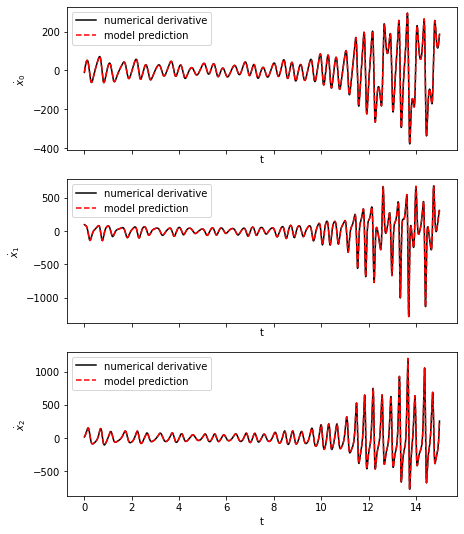

In [39]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test, u=u_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

### Simulate forward in time (control input function known)
When working with control inputs `SINDy.simulate` requires a *function* to be passed in for the control inputs, `u`, because the default integrator used in `SINDy.simulate` uses adaptive time-stepping. We show what to do in the case when you do not know the functional form for the control inputs in the example following this one.

/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


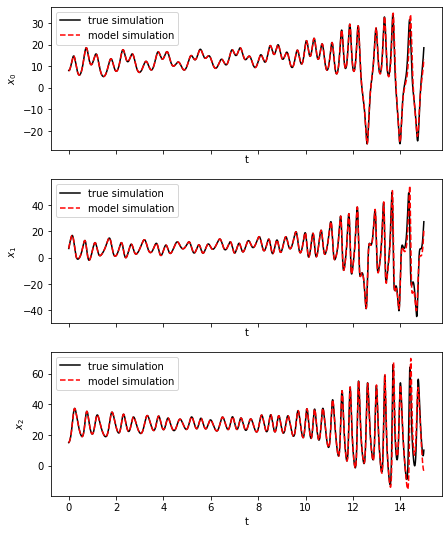

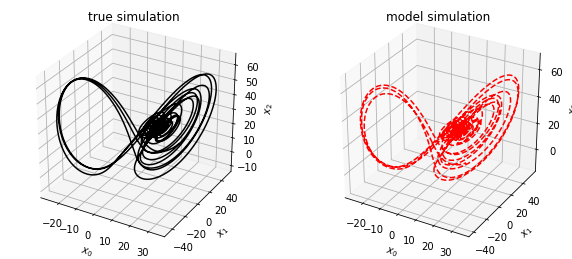

In [40]:
# Evolve the new initial condition in time with the SINDy model
x_test_sim = model.simulate(x0_test, t_test, u=u_fun)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()

### Simulate forward in time (unknown control input function)
If you only have a vector of control input values at the times in `t_test` and do not know the functional form for `u`, the `simulate` function will internally form an interpolating function based on the vector of control inputs. As a consequence of this interpolation procedure, `simulate` will not give a state estimate for the last time point in `t_test`. This is because the default integrator, `scipy.integrate.odeint`, is adaptive and sometimes attempts to evaluate the interpolant outside the domain of interpolation, causing an error.

In [41]:
u_test = u_fun(t_test)

/Users/alankaptanoglu/pysindy/pysindy/pysindy.py:882: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  "Last time point dropped in simulation because interpolation"


Lenght of t_test: 7500
Lenght of simulation: 7499


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


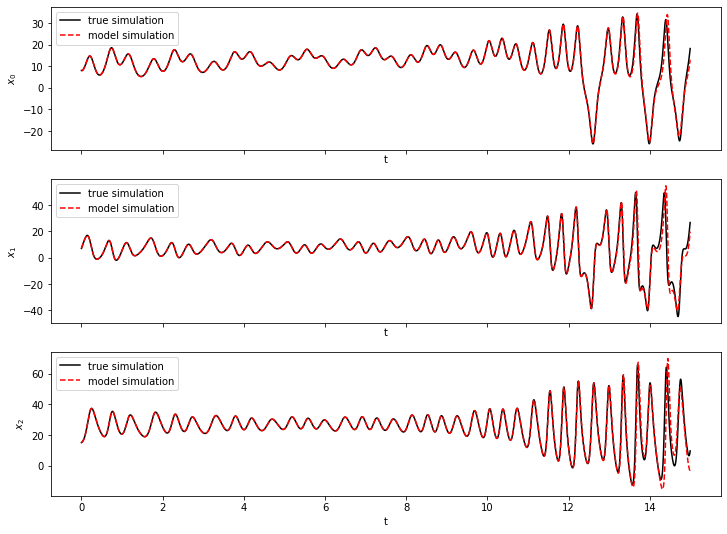

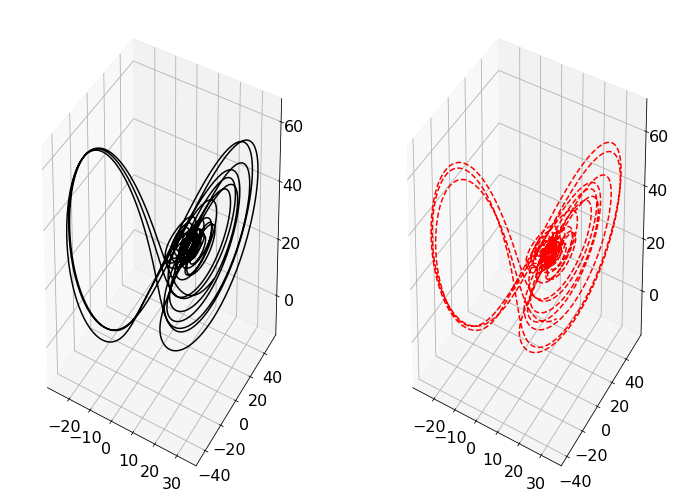

In [42]:
x_test_sim = model.simulate(x0_test, t_test, u=u_test)

# Note that the output is one example short of the length of t_test
print('Lenght of t_test:',len(t_test))
print('Lenght of simulation:',len(x_test_sim))

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(12, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test[:-1], x_test[:-1, i], 'k', label='true simulation')
    axs[i].plot(t_test[:-1], x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.zaxis.set_tick_params(labelsize=16)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax2.zaxis.set_tick_params(labelsize=16)

fig.show()
plt.savefig('lorenz_control.pdf')